# VAR 

Data fra 2000-01-31 til 2025-11-30
Antall observasjoner: 311
Kolonner: ['EUR_NOK', 'Q', 'd_pi', 'dI_t', 'Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']
Log-transformerte Q.

3) Walk-forward Monthly VAR – strict OOS
Antall månedlige prognoser: 287

=== Walk-forward Monthly VAR (OOS) ===
Observasjoner:         287
RMSE:                  0.2285
MAE:                   0.1622
Treffsikkerhet (retning): 47.6%

=== Diebold–Mariano vs Random Walk (Monthly, VAR) ===
DM-statistikk: 1.3561
p-verdi:       0.1751


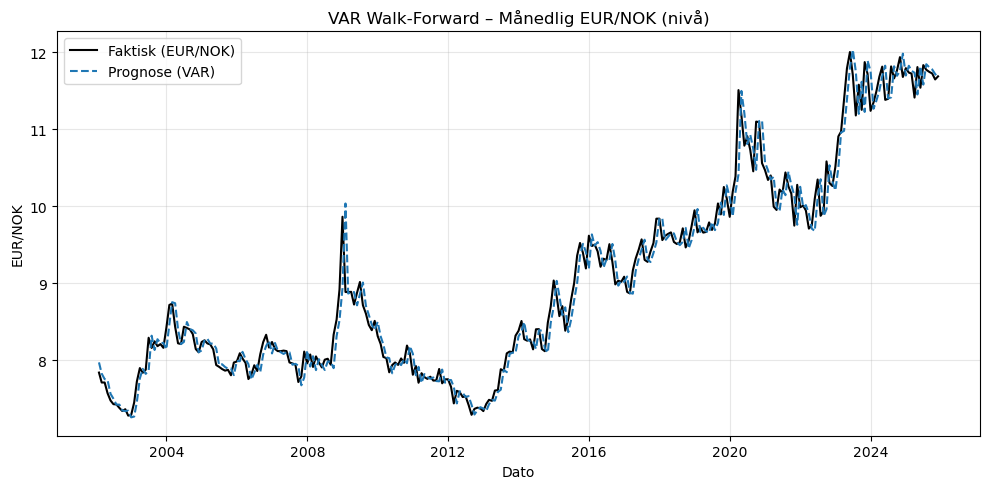


4) Walk-forward Quarterly VAR – strict OOS (aggregert fra måned)

=== Walk-forward Quarterly VAR (OOS, aggregated) ===
Observasjoner (kvartal):    96
RMSE (kvartalsnivå):        0.1307
MAE  (kvartalsnivå):        0.0886
Treffsikkerhet (retning):   85.3%

=== Diebold–Mariano vs Random Walk (Quarterly, VAR) ===
DM-statistikk: -4.2142
p-verdi:       0.0000


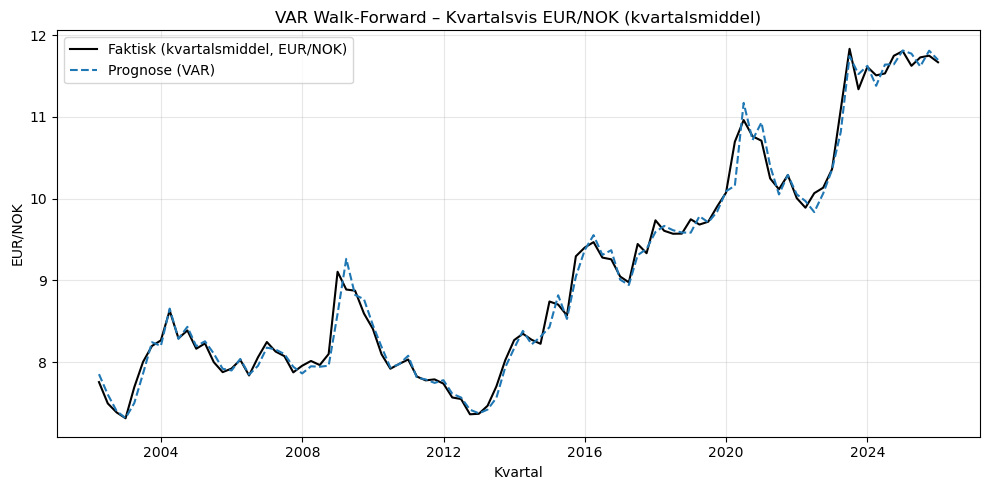

In [10]:
# ==============================================
# VAR monthly & quarterly – strict walk-forward OOS
# Endogenous block: Q, d_pi, dI_t  (Q in logs)
# Target: EUR/NOK (nivå)
# ==============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings

warnings.filterwarnings("ignore")

# -------------------------------------------------
# 0) Diebold–Mariano test helper
# -------------------------------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF uten scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """
    Diebold–Mariano test for lik prediksjonsnøyaktighet.

    Parametere
    ----------
    y_true  : faktiske verdier
    y_model : prognoser fra modell
    y_rw    : prognoser fra benchmark (f.eks. random walk)
    h       : prognosehorisont (her brukes h=1)
    loss    : "mse" eller "mae"

    Returnerer
    ----------
    (DM-statistikk, p-verdi)
    """
    df = pd.concat(
        {"y": pd.Series(y_true), "m": pd.Series(y_model), "rw": pd.Series(y_rw)},
        axis=1,
    ).dropna()

    if len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]

    if loss.lower() == "mae":
        d = np.abs(e_m) - np.abs(e_r)
    else:  # mse
        d = (e_m ** 2) - (e_r ** 2)

    N = len(d)
    d_mean = d.mean()

    # HAC-varians (Newey–West med Bartlett-vekter) opp til lag h-1
    gamma0 = np.var(d, ddof=1)
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = np.cov(d[k:], d[:-k], ddof=1)[0, 1]
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / np.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return float(dm_stat), float(p_val)


# -------------------------------------------------
# 1) Last inn månedlig datasett
# -------------------------------------------------
# NB: bytt gjerne til lokal filsti hvis du bruker vedlagt fil:
# url = "variables_monthly.csv"
url = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_monthly.csv"
)

df = pd.read_csv(url)

# Standardiser dato-kolonnen
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
elif "DATE" in df.columns:
    df["Date"] = pd.to_datetime(df["DATE"])
else:
    raise KeyError("Fant verken 'Date' eller 'DATE' i kolonnenavnene.")

df = df.sort_values("Date").set_index("Date")

print(f"Data fra {df.index.min().date()} til {df.index.max().date()}")
print(f"Antall observasjoner: {len(df)}")
print("Kolonner:", list(df.columns))


# -------------------------------------------------
# 2) Konstruer endogen blokk + målvariabel
# -------------------------------------------------
endog_vars = ["Q", "d_pi", "dI_t"]  # som i artikkelen
target_var = "EUR_NOK"

df = df.copy()

# Sjekk om Q allerede er i logg. Hvis Q-verdiene er ~0.8–1.2 er det nivåer,
# hvis de er rundt -0.5 til 0.5 er de sannsynligvis logget allerede.
if df["Q"].max() > 5:  # veldig grov sjekk; juster etter behov
    raise ValueError(
        "Q ser veldig stor ut – sjekk om Q er definert riktig i datasettet."
    )

# Anta at Q er i nivåer (real rate), og ta logg:
if df["Q"].min() > 0 and df["Q"].max() < 5:
    df["Q"] = np.log(df["Q"])
    print("Log-transformerte Q.")
else:
    print("Q ser ut til å være logget allerede – log-transformasjon hoppet over.")

endog_m = df[endog_vars].copy()
eur_nok_m = df[target_var].copy()

# logg av nominell kurs (brukes til å danne prisgap)
s_log = np.log(eur_nok_m)

dates = endog_m.index


# -------------------------------------------------
# 3) Walk-forward VAR på månedsfrekvens (strengt OOS)
# -------------------------------------------------
# Parametere
p = 2          # VAR-laglengde (fast; du kan eventuelt velge med AIC/BIC)
min_train = 24 # minst 24 mnd historikk før første prognose

rows = []

for i in range(min_train, len(dates)):
    d_prev = dates[i - 1]  # siste in-sample måned
    d_curr = dates[i]      # måneden vi skal predikere

    # Expanding window: all data t.o.m. d_prev
    endog_train = endog_m.loc[:d_prev]

    # 3a) Estimer VAR(p) på endogen blokk
    model = VAR(endog_train)
    res = model.fit(p)

    # 3b) 1-stegs prognose for [Q, d_pi, dI_t] i måned d_curr
    y0 = endog_train.values[-p:]          # siste p observasjoner
    f_vec = res.forecast(y0, steps=1)[0]  # vektor prognoser
    f = pd.Series(f_vec, index=endog_vars)

    q_hat = f["Q"]      # prognose for log Q_t
    dpi_hat = f["d_pi"] # prognose for d_pi_t

    # 3c) Prisgapet ved t-1 (log): g_{t-1} = s_{t-1} - q_{t-1}
    q_prev = endog_train["Q"].iloc[-1]
    s_prev = s_log.loc[d_prev]
    g_prev = s_prev - q_prev

    # 3d) Prisgap-dynamikk:
    # g_t = g_{t-1} + d_pi_t, siden d_pi_t = (dp_t - dp_{t-1})
    # NB: dette forutsetter at d_pi er i samme skala som dp-veksten
    g_new = g_prev + dpi_hat   # <-- KORRIGERT TEGN (pluss, ikke minus!)

    # 3e) Rekonstruer nominell log-kurs: s_t = q_t + g_t
    s_hat = q_hat + g_new

    # Tilbake til nivå: EUR/NOK
    y_pred = float(np.exp(s_hat))
    y_true = float(eur_nok_m.loc[d_curr])

    rows.append({"date": d_curr, "y_true": y_true, "y_pred": y_pred})

df_eval_m = pd.DataFrame(rows).set_index("date").sort_index()

print("\n==============================")
print("3) Walk-forward Monthly VAR – strict OOS")
print("==============================")
print(f"Antall månedlige prognoser: {len(df_eval_m)}")


# -------------------------------------------------
# 3b) Evaluer månedlige prognoser
# -------------------------------------------------
rmse_m = np.sqrt(mean_squared_error(df_eval_m["y_true"], df_eval_m["y_pred"]))
mae_m = mean_absolute_error(df_eval_m["y_true"], df_eval_m["y_pred"])

# Retnings-treff: sign på endring relativt til forrige faktisk nivå
df_eval_m["y_prev"] = df_eval_m["y_true"].shift(1)
mask_m = df_eval_m["y_prev"].notna()

dir_true_m = np.sign(df_eval_m.loc[mask_m, "y_true"] - df_eval_m.loc[mask_m, "y_prev"])
dir_pred_m = np.sign(df_eval_m.loc[mask_m, "y_pred"] - df_eval_m.loc[mask_m, "y_prev"])
hit_rate_m = (dir_true_m == dir_pred_m).mean() * 100

print("\n=== Walk-forward Monthly VAR (OOS) ===")
print(f"Observasjoner:         {len(df_eval_m)}")
print(f"RMSE:                  {rmse_m:.4f}")
print(f"MAE:                   {mae_m:.4f}")
print(f"Treffsikkerhet (retning): {hit_rate_m:.1f}%")

# DM-test vs random walk (RW_t = y_{t-1})
df_eval_m["rw_pred"] = df_eval_m["y_true"].shift(1)
dm_stat_m, p_val_m = dm_test(
    df_eval_m["y_true"], df_eval_m["y_pred"], df_eval_m["rw_pred"],
    h=1, loss="mse"
)

print("\n=== Diebold–Mariano vs Random Walk (Monthly, VAR) ===")
print(f"DM-statistikk: {dm_stat_m:.4f}")
print(f"p-verdi:       {p_val_m:.4f}")

# Plot: månedlige prognoser
plt.figure(figsize=(10, 5))
plt.plot(df_eval_m.index, df_eval_m["y_true"], color="black", label="Faktisk (EUR/NOK)")
plt.plot(df_eval_m.index, df_eval_m["y_pred"], color="tab:blue", linestyle="--",
         label="Prognose (VAR)")
plt.title("VAR Walk-Forward – Månedlig EUR/NOK (nivå)")
plt.xlabel("Dato")
plt.ylabel("EUR/NOK")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("VAR_WalkForward_Monthly.png", dpi=300, bbox_inches="tight")
plt.show()


# -------------------------------------------------
# 4) Kvartals-VAR WF = aggregering av månedlige prognoser
# -------------------------------------------------
# Her tar vi bare gjennomsnittet av månedlig faktisk og prognose
# pr. kvartal. (Alternativ: siste måned i kvartalet i stedet for mean.)
df_q = df_eval_m[["y_true", "y_pred"]].resample("Q").mean().dropna()
df_q.rename(columns={"y_true": "y_true_q", "y_pred": "y_pred_q"}, inplace=True)

print("\n==============================")
print("4) Walk-forward Quarterly VAR – strict OOS (aggregert fra måned)")
print("==============================")

rmse_q = np.sqrt(mean_squared_error(df_q["y_true_q"], df_q["y_pred_q"]))
mae_q = mean_absolute_error(df_q["y_true_q"], df_q["y_pred_q"])

df_q["y_prev_q"] = df_q["y_true_q"].shift(1)
mask_q = df_q["y_prev_q"].notna()

dir_true_q = np.sign(df_q.loc[mask_q, "y_true_q"] - df_q.loc[mask_q, "y_prev_q"])
dir_pred_q = np.sign(df_q.loc[mask_q, "y_pred_q"] - df_q.loc[mask_q, "y_prev_q"])
hit_rate_q = (dir_true_q == dir_pred_q).mean() * 100

print("\n=== Walk-forward Quarterly VAR (OOS, aggregated) ===")
print(f"Observasjoner (kvartal):    {len(df_q)}")
print(f"RMSE (kvartalsnivå):        {rmse_q:.4f}")
print(f"MAE  (kvartalsnivå):        {mae_q:.4f}")
print(f"Treffsikkerhet (retning):   {hit_rate_q:.1f}%")

# Kvartalsvis DM-test vs random walk
df_q["rw_pred_q"] = df_q["y_true_q"].shift(1)
dm_stat_q, p_val_q = dm_test(
    df_q["y_true_q"], df_q["y_pred_q"], df_q["rw_pred_q"],
    h=1, loss="mse"
)

print("\n=== Diebold–Mariano vs Random Walk (Quarterly, VAR) ===")
print(f"DM-statistikk: {dm_stat_q:.4f}")
print(f"p-verdi:       {p_val_q:.4f}")

# Plot: kvartalsprognoser
plt.figure(figsize=(10, 5))
plt.plot(df_q.index, df_q["y_true_q"], color="black",
         label="Faktisk (kvartalsmiddel, EUR/NOK)")
plt.plot(df_q.index, df_q["y_pred_q"], color="tab:blue", linestyle="--",
         label="Prognose (VAR)")
plt.title("VAR Walk-Forward – Kvartalsvis EUR/NOK (kvartalsmiddel)")
plt.xlabel("Kvartal")
plt.ylabel("EUR/NOK")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("VAR_WalkForward_Quarterly.png", dpi=300, bbox_inches="tight")
plt.show()


Data from 2000-01-31 to 2025-11-30
Total observations: 311
Columns: ['EUR_NOK', 'Q', 'd_pi', 'dI_t', 'Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']

3) Walk-forward Monthly VAR – strict OOS
Completed 287 monthly forecasts.

=== Walk-forward Monthly VAR (OOS) ===
Observations: 287
RMSE: 0.2283
MAE:  0.1628
Directional accuracy: 49.7%

=== Diebold–Mariano vs Random Walk (Monthly, VAR) ===
DM-statistic: 1.4662
p-value     : 0.1426


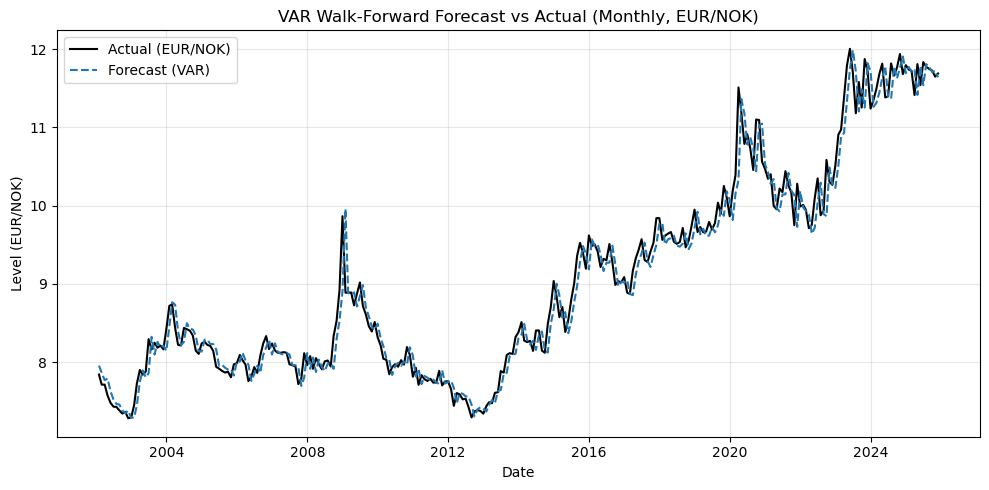


4) Walk-forward Quarterly VAR – strict OOS (aggregated from monthly WF)

=== Walk-forward Quarterly VAR (OOS, aggregated) ===
Observations: 96
RMSE (quarterly): 0.1363
MAE  (quarterly): 0.0925
Directional accuracy (quarterly): 80.0%

=== Diebold–Mariano vs Random Walk (Quarterly, VAR) ===
DM-statistic: -4.2062
p-value     : 0.0000


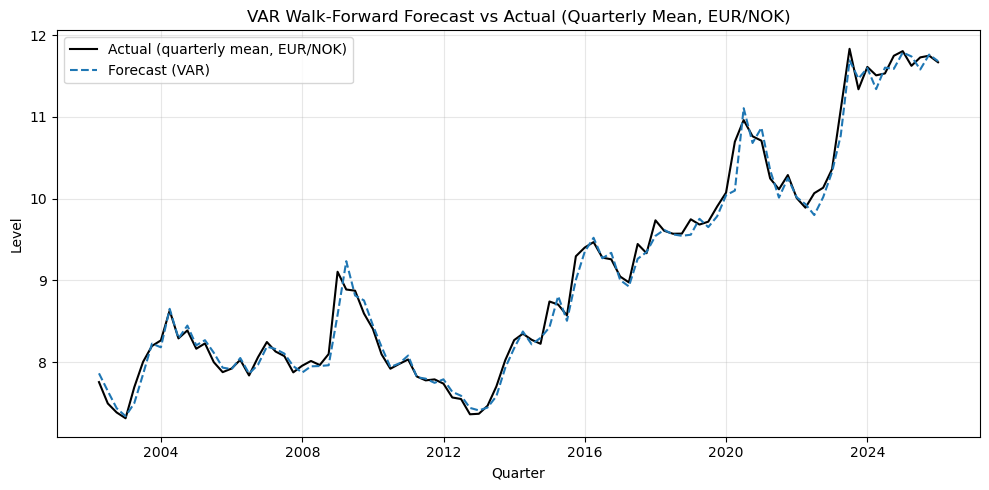

In [5]:
# ==============================================
# VAR monthly & quarterly – strict walk-forward OOS
# Endogenous block: Q, d_pi, dI_t  (Q in logs)
# Data source: variables_monthly.csv (2000–2025)
# ==============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings

warnings.filterwarnings("ignore")

# ----------------------------
# 0) DM test helper
# ----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF (no scipy)."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """
    Diebold–Mariano test for equal predictive accuracy.

    Parameters:
        y_true  : actual values
        y_model : model forecast
        y_rw    : benchmark forecast (e.g. random walk)
        h       : forecast horizon (use h=1 here)
        loss    : "mse" or "mae"

    Returns:
        (DM statistic, p-value)
    """
    df = pd.concat(
        {"y": pd.Series(y_true), "m": pd.Series(y_model), "rw": pd.Series(y_rw)},
        axis=1,
    ).dropna()

    if len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]

    if loss.lower() == "mae":
        d = np.abs(e_m) - np.abs(e_r)
    else:  # mse
        d = (e_m ** 2) - (e_r ** 2)

    N = len(d)
    d_mean = d.mean()

    # HAC variance with Bartlett weights up to lag h-1
    gamma0 = np.var(d, ddof=1)
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = np.cov(d[k:], d[:-k], ddof=1)[0, 1]
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / np.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return float(dm_stat), float(p_val)


# ----------------------------
# 1) Load monthly dataset
# ----------------------------
url = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_monthly.csv"
)

df = pd.read_csv(url)

# Standardise date index
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
elif "DATE" in df.columns:
    df["Date"] = pd.to_datetime(df["DATE"])
else:
    raise KeyError("Neither 'Date' nor 'DATE' found in column names.")

df = df.sort_values("Date").set_index("Date")

print(f"Data from {df.index.min().date()} to {df.index.max().date()}")
print(f"Total observations: {len(df)}")
print("Columns:", list(df.columns))

# ----------------------------
# 2) Construct endogenous block + target
# ----------------------------
endog_vars = ["Q", "d_pi", "dI_t"]
target_var = "EUR_NOK"

df = df.copy()
df["Q"] = np.log(df["Q"])          # log real exchange rate
endog_m = df[endog_vars]
eur_nok_m = df[target_var]

dates = endog_m.index

# ----------------------------
# 3) Walk-forward VAR at monthly frequency (strict OOS)
# ----------------------------
p = 2                 # VAR lag length (fixed)
min_train = 24        # minimum history (months) before first forecast

rows = []
for i in range(min_train, len(dates)):
    d_prev = dates[i - 1]  # last in-sample month
    d_curr = dates[i]      # month to forecast

    # expanding window up to previous month
    endog_train = endog_m.loc[:d_prev]

    # fit VAR(p) on endogenous block
    model = VAR(endog_train)
    res = model.fit(p)

    # 1-step ahead forecast of [Q, d_pi, dI_t] for month d_curr
    # initial state = last p observations
    y0 = endog_train.values[-p:]
    f_vec = res.forecast(y0, steps=1)[0]
    f = pd.Series(f_vec, index=endog_vars)

    q_hat = f["Q"]
    dpi_hat = f["d_pi"]

    # Price gap at t-1: g_{t-1} = s_{t-1} - q_{t-1}
    q_prev = endog_train["Q"].iloc[-1]
    s_prev = np.log(eur_nok_m.loc[d_prev])
    g_prev = s_prev - q_prev

    # Forecast price gap at t and reconstruct s_t
    g_new = g_prev - dpi_hat          # g_t = g_{t-1} - d_pi_t
    s_hat = q_hat + g_new
    y_pred = float(np.exp(s_hat))     # nominal EUR/NOK level

    y_true = float(eur_nok_m.loc[d_curr])

    rows.append({"date": d_curr, "y_true": y_true, "y_pred": y_pred})

df_eval_m = pd.DataFrame(rows).set_index("date").sort_index()

print("\n==============================")
print("3) Walk-forward Monthly VAR – strict OOS")
print("==============================")
print(f"Completed {len(df_eval_m)} monthly forecasts.")

# Monthly metrics
rmse_m = np.sqrt(mean_squared_error(df_eval_m["y_true"], df_eval_m["y_pred"]))
mae_m = mean_absolute_error(df_eval_m["y_true"], df_eval_m["y_pred"])

df_eval_m["y_prev"] = df_eval_m["y_true"].shift(1)
mask_m = df_eval_m["y_prev"].notna()
dir_true_m = np.sign(df_eval_m.loc[mask_m, "y_true"] - df_eval_m.loc[mask_m, "y_prev"])
dir_pred_m = np.sign(df_eval_m.loc[mask_m, "y_pred"] - df_eval_m.loc[mask_m, "y_prev"])
hit_rate_m = (dir_true_m == dir_pred_m).mean() * 100

print("\n=== Walk-forward Monthly VAR (OOS) ===")
print(f"Observations: {len(df_eval_m)}")
print(f"RMSE: {rmse_m:.4f}")
print(f"MAE:  {mae_m:.4f}")
print(f"Directional accuracy: {hit_rate_m:.1f}%")

# Monthly DM vs random walk (RW_t = y_{t-1})
df_eval_m["rw_pred"] = df_eval_m["y_true"].shift(1)
dm_stat_m, p_val_m = dm_test(
    df_eval_m["y_true"], df_eval_m["y_pred"], df_eval_m["rw_pred"],
    h=1, loss="mse"
)

print("\n=== Diebold–Mariano vs Random Walk (Monthly, VAR) ===")
print(f"DM-statistic: {dm_stat_m:.4f}")
print(f"p-value     : {p_val_m:.4f}")

# Plot monthly WF
plt.figure(figsize=(10, 5))
plt.plot(df_eval_m.index, df_eval_m["y_true"], color="black", label="Actual (EUR/NOK)")
plt.plot(df_eval_m.index, df_eval_m["y_pred"], color="tab:blue", linestyle="--",
         label="Forecast (VAR)")
plt.title("VAR Walk-Forward Forecast vs Actual (Monthly, EUR/NOK)")
plt.xlabel("Date")
plt.ylabel("Level (EUR/NOK)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("VAR_WalkForward_Monthly.png", dpi=300, bbox_inches="tight")
plt.show()


# ----------------------------
# 4) Quarterly VAR WF = quarterly aggregation of monthly WF
# ----------------------------
# Use only strictly OOS monthly forecasts we just produced
df_q = df_eval_m[["y_true", "y_pred"]].resample("Q").mean().dropna()
df_q.rename(columns={"y_true": "y_true_q", "y_pred": "y_pred_q"}, inplace=True)

print("\n==============================")
print("4) Walk-forward Quarterly VAR – strict OOS (aggregated from monthly WF)")
print("==============================")

rmse_q = np.sqrt(mean_squared_error(df_q["y_true_q"], df_q["y_pred_q"]))
mae_q = mean_absolute_error(df_q["y_true_q"], df_q["y_pred_q"])

df_q["y_prev_q"] = df_q["y_true_q"].shift(1)
mask_q = df_q["y_prev_q"].notna()
dir_true_q = np.sign(df_q.loc[mask_q, "y_true_q"] - df_q.loc[mask_q, "y_prev_q"])
dir_pred_q = np.sign(df_q.loc[mask_q, "y_pred_q"] - df_q.loc[mask_q, "y_prev_q"])
hit_rate_q = (dir_true_q == dir_pred_q).mean() * 100

print("\n=== Walk-forward Quarterly VAR (OOS, aggregated) ===")
print(f"Observations: {len(df_q)}")
print(f"RMSE (quarterly): {rmse_q:.4f}")
print(f"MAE  (quarterly): {mae_q:.4f}")
print(f"Directional accuracy (quarterly): {hit_rate_q:.1f}%")

# Quarterly DM vs random walk (RW_q = previous quarter's mean)
df_q["rw_pred_q"] = df_q["y_true_q"].shift(1)
dm_stat_q, p_val_q = dm_test(
    df_q["y_true_q"], df_q["y_pred_q"], df_q["rw_pred_q"],
    h=1, loss="mse"
)

print("\n=== Diebold–Mariano vs Random Walk (Quarterly, VAR) ===")
print(f"DM-statistic: {dm_stat_q:.4f}")
print(f"p-value     : {p_val_q:.4f}")

# Plot quarterly WF
plt.figure(figsize=(10, 5))
plt.plot(df_q.index, df_q["y_true_q"], color="black",
         label="Actual (quarterly mean, EUR/NOK)")
plt.plot(df_q.index, df_q["y_pred_q"], color="tab:blue", linestyle="--",
         label="Forecast (VAR)")
plt.title("VAR Walk-Forward Forecast vs Actual (Quarterly Mean, EUR/NOK)")
plt.xlabel("Quarter")
plt.ylabel("Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("VAR_WalkForward_Quarterly.png", dpi=300, bbox_inches="tight")
plt.show()


# NEW VARX

            y_true    y_pred
date                        
2002-01-31   7.841  7.786060
2002-02-28   7.712  7.848396
2002-03-31   7.712  7.792941
2002-04-30   7.573  7.825283
2002-05-31   7.478  7.607691

=== VARX Monthly WF ===
Obs: 287
RMSE: 0.2274
MAE : 0.1654
DM-stat: 1.3737, p=0.1695


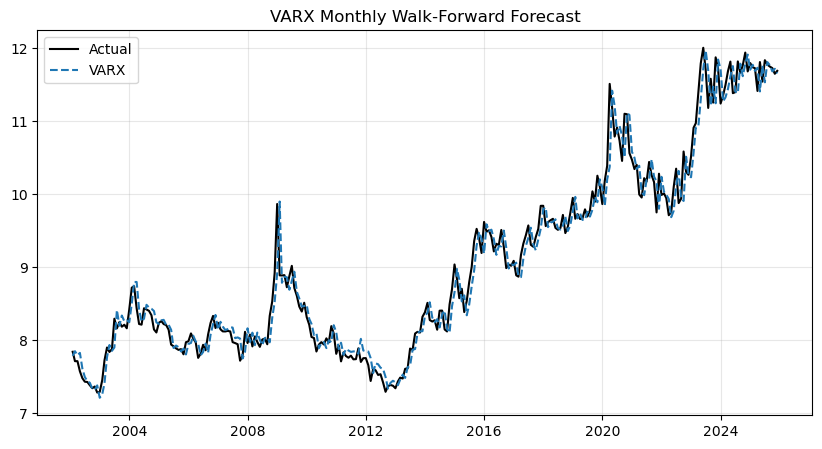

In [8]:
# =====================================================
# CORRECT VARX monthly – strict walk-forward OOS
# Endog: Q, d_pi, dI_t
# Exog : Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy
# Uses statsmodels VAR with exog (stable)
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math, warnings
warnings.filterwarnings("ignore")

# ----------------------------
# DM test
# ----------------------------
def _normal_cdf(z):
    return 0.5 * (1 + math.erf(z / math.sqrt(2)))

def dm_test(y_true, y_model, y_rw):
    df = pd.concat({"y":y_true, "m":y_model, "rw":y_rw}, axis=1).dropna()
    if len(df) < 5:
        return np.nan, np.nan

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = (e_m**2 - e_r**2)
    N = len(d)

    dm_stat = d.mean() / np.sqrt(np.var(d, ddof=1) / N)
    p_val = 2 * (1 - _normal_cdf(abs(dm_stat)))
    return float(dm_stat), float(p_val)


# ----------------------------
# Load data
# ----------------------------
url = "https://raw.githubusercontent.com/bredeespelid/Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_monthly.csv"
df = pd.read_csv(url)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

endog_vars = ["Q", "d_pi", "dI_t"]
exog_vars  = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]

df = df.copy()
df["Q"] = np.log(df["Q"])
for v in exog_vars:
    df[v] = np.log(df[v])

endog_m = df[endog_vars]
exog_m  = df[exog_vars]
eur_nok = df["EUR_NOK"]
dates = df.index

# ----------------------------
# Walk-forward
# ----------------------------
p = 2
min_train = 24
rows = []

for i in range(min_train, len(dates)):
    d_prev = dates[i-1]
    d_curr = dates[i]

    Y_train = endog_m.loc[:d_prev]
    X_train = exog_m.loc[:d_prev]

    # FIT VARX SAFELY (OLS)
    model = VAR(Y_train, exog=X_train)
    res = model.fit(p)

    # Forecast using next exog month
    X_next = exog_m.loc[[d_curr]]
    f = res.forecast(Y_train.values[-p:], steps=1, exog_future=X_next.values)[0]
    f = pd.Series(f, index=endog_vars)

    q_hat = f["Q"]
    dpi_hat = f["d_pi"]

    # Price gap
    q_prev = Y_train["Q"].iloc[-1]
    s_prev = np.log(eur_nok.loc[d_prev])
    g_prev = s_prev - q_prev

    g_new = g_prev - dpi_hat
    s_hat = q_hat + g_new
    y_pred = float(np.exp(s_hat))

    y_true = float(eur_nok.loc[d_curr])
    rows.append({"date": d_curr, "y_true": y_true, "y_pred": y_pred})

df_varx_m = pd.DataFrame(rows).set_index("date")
print(df_varx_m.head())

# ----------------------------
# Metrics
# ----------------------------
rmse = np.sqrt(mean_squared_error(df_varx_m["y_true"], df_varx_m["y_pred"]))
mae  = mean_absolute_error(df_varx_m["y_true"], df_varx_m["y_pred"])

df_varx_m["rw_pred"] = df_varx_m["y_true"].shift(1)
dm, p = dm_test(df_varx_m["y_true"], df_varx_m["y_pred"], df_varx_m["rw_pred"])

print("\n=== VARX Monthly WF ===")
print(f"Obs: {len(df_varx_m)}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"DM-stat: {dm:.4f}, p={p:.4f}")

plt.figure(figsize=(10,5))
plt.plot(df_varx_m.index, df_varx_m["y_true"], label="Actual", color="black")
plt.plot(df_varx_m.index, df_varx_m["y_pred"], "--", label="VARX", color="tab:blue")
plt.title("VARX Monthly Walk-Forward Forecast")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



=== VARX Quarterly WF ===
Obs:   96
RMSE:  0.1358
MAE:   0.0964
DM Q:  -4.2115, p=0.0000


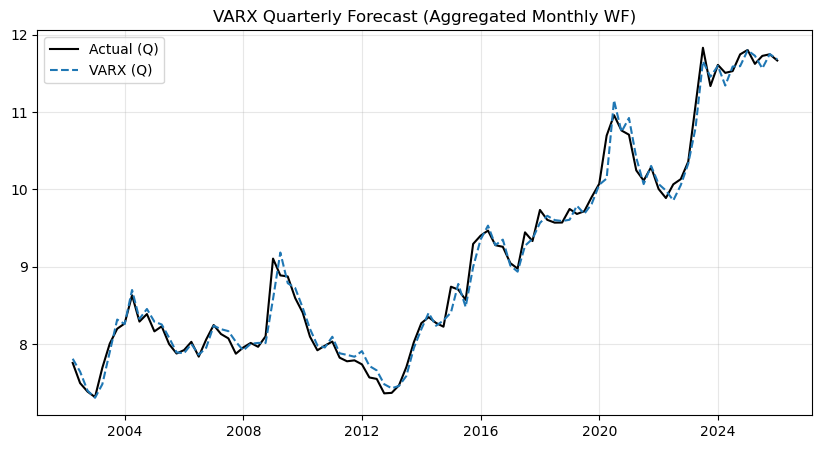

In [9]:
# ===================================
# quarterly VARX = aggregate monthly WF
# ===================================

df_q = df_varx_m[["y_true", "y_pred"]].resample("Q").mean().dropna()
df_q.rename(columns={"y_true":"y_true_q", "y_pred":"y_pred_q"}, inplace=True)

rmse_q = np.sqrt(mean_squared_error(df_q["y_true_q"], df_q["y_pred_q"]))
mae_q  = mean_absolute_error(df_q["y_true_q"], df_q["y_pred_q"])

df_q["rw_q"] = df_q["y_true_q"].shift(1)
dm_q, p_q = dm_test(df_q["y_true_q"], df_q["y_pred_q"], df_q["rw_q"])

print("\n=== VARX Quarterly WF ===")
print(f"Obs:   {len(df_q)}")
print(f"RMSE:  {rmse_q:.4f}")
print(f"MAE:   {mae_q:.4f}")
print(f"DM Q:  {dm_q:.4f}, p={p_q:.4f}")

plt.figure(figsize=(10,5))
plt.plot(df_q.index, df_q["y_true_q"], color="black", label="Actual (Q)")
plt.plot(df_q.index, df_q["y_pred_q"], "--", color="tab:blue", label="VARX (Q)")
plt.title("VARX Quarterly Forecast (Aggregated Monthly WF)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
